# Chilean sign language static alphabet gestures recognition using ConvNets on Pytorch

In [2]:
%%HTML
<style>
.container {
    width:90% ! important;
}
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
.rendered_html { 
    font-size:0.8em; 
}
.rendered_html table{
    width: 80%;
    margin-left:auto; 
    margin-right:auto;
    padding: 20px;
    border: 0px solid black;    
    background-color: #ff;
}
.rendered_html td, .rendered_html th 
{
    vertical-align: top;
    text-align: left;
    font-size: 14px;
    font-face: sans-serif;
}
</style>

In [3]:
from __future__ import division
import numpy as np
import os

from PIL import Image

from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
from torch.utils import data
from torchvision import transforms, datasets
import torchvision
from matplotlib import pyplot as plt
import matplotlib
import random
%matplotlib inline
import hiddenlayer as hl

from dataset.dataset import * 
from models.models import *
from util.util import *

# Show transforms of a single random image from dataset

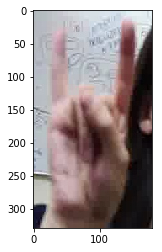

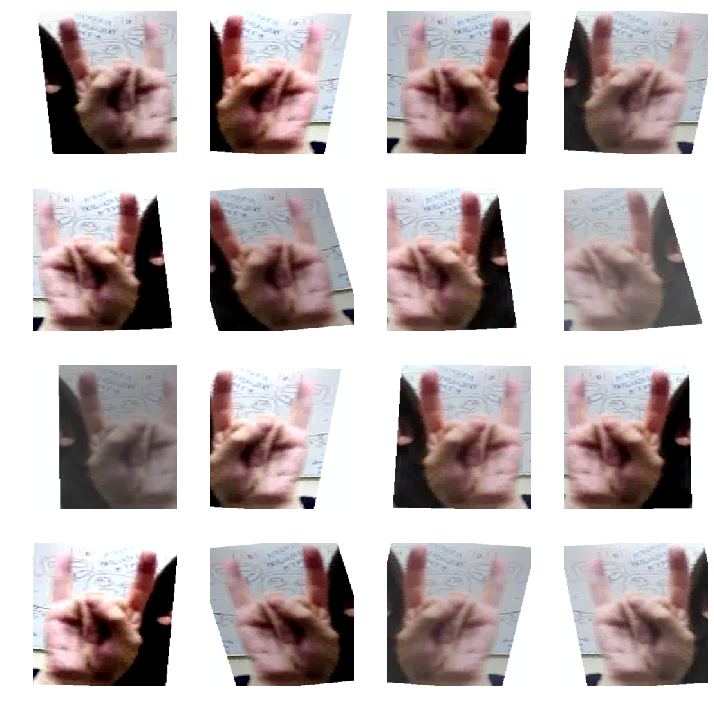

In [4]:
test_img_folder = 'balanced/'
r = random.choice(os.listdir(test_img_folder)) #change dir name to whatever
img_path = test_img_folder + r

ex_img = Image.open(img_path)

plt.imshow(ex_img)

transforms = get_image_transforms()
plt.figure(figsize=(10, 10))

for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    _ = imshow_tensor(transforms['train'](ex_img), ax=ax)

plt.tight_layout()

# Create dataloaders

In [5]:
img_dataset_path = 'balanced/'
partition = {'train':[], 'validation':[], 'test':[]}
labels = {}
classes = list('ABCDEFHIKLMNOPQRTUVWY')
n_classes = len(classes)
files = os.listdir(img_dataset_path)
random.shuffle(files)

c = 0
N = len(files)

for name in files:
    #80% train
    #10% valid
    #10% test
    if(c>=N*0.2):
        partition['train'].append(name)
    if(c<N*0.2):
        if(c<=N*0.1):
            partition['validation'].append(name)
        else:
            partition['test'].append(name)
    labels[name] = classes.index(name[0])
    c = c + 1

# Parameters
params = {'batch_size': 64, 'shuffle' : True}

# Generators
training_set = Signs_Dataset(partition['train'], labels, 
                             img_path = img_dataset_path, transform=transforms['train'])
validation_set = Signs_Dataset(partition['validation'], labels, 
                               img_path = img_dataset_path, transform=transforms['valid'])
test_set = Signs_Dataset(partition['test'], labels,
                         img_path = img_dataset_path, transform=transforms['valid'])

#Dataloaders
train_loader = data.DataLoader(training_set, **params)
valid_loader = data.DataLoader(validation_set, **params)
test_loader = data.DataLoader(test_set, **params)

print("Dataloaders done")

Dataloaders done


# Model selection

## 1. Transfer Learning on VGG16 pretrained model(two options below: 1.a. or 1.b.)

In [6]:
model = torchvision.models.vgg16(pretrained=True)
model.name = 'VGG16'
print(model.name)
# Freeze training for all layers
for param in model.parameters():
    param.requires_grad = False
print(model)

VGG16
VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): 

### 1.a. Replace the last Linear layer on Classifier module

In [7]:
# Get number of in features from classifier layers
n_classifier_inputs_6 = model.classifier[6].in_features

#Replace last Linear layer on classifier
model.classifier[6] = torch.nn.Linear(n_classifier_inputs_6, n_classes)
print(model.classifier)

loss = torch.nn.CrossEntropyLoss()

#Define the optimizer just for clasifier module layers
optimizer = torch.optim.Adam(model.classifier.parameters(), lr=1e-3)

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace)
  (2): Dropout(p=0.5)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace)
  (5): Dropout(p=0.5)
  (6): Linear(in_features=4096, out_features=21, bias=True)
)


### 1.b. Replace the entire classifier module

In [ ]:
# Get number of in features from classifier layers
n_classifier_inputs = model.classifier[0].in_features

#Or replace all the classifier module layers
fc = torch.nn.Sequential(
    torch.nn.Linear(n_classifier_inputs, 460),
    torch.nn.ReLU(),
    torch.nn.Dropout(0.4),
    torch.nn.Linear(460, n_classes),
    torch.nn.LogSoftmax(dim=1)
)
model.classifier = fc
print(model.classifier)

loss = torch.nn.NLLLoss()
#Define the optimizer just for clasifier module layers
optimizer = torch.optim.Adam(model.classifier.parameters(), lr=1e-3)

## 1.c. Verify number of trainable parameters

In [7]:
count_parameters(model)

86037

## 2. Select a different model

In [ ]:
#model = LeNet5(n_output=21) 
#model_name =  'LeNet5'
model = AlexNet(n_classes)
model_name =  'AlexNet'
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

## Enable GPU

In [8]:
use_gpu = True
if use_gpu:
    model = model.cuda()
#print(model)

# Train the model

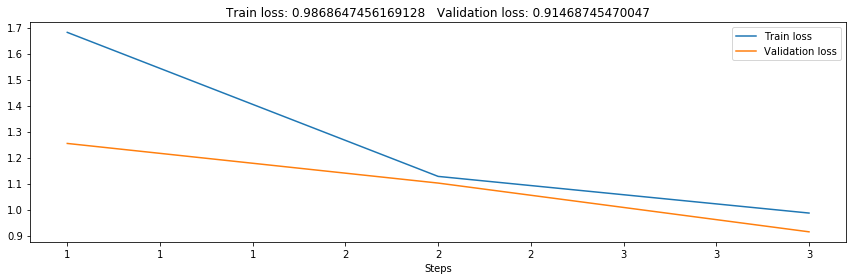

Epoch 3: Train loss 0.9869, Valid loss 0.9147
Model  VGG16  trained for  3 epochs


In [9]:
def train(epochs, train_loader, valid_loader):
    h = hl.History()
    c = hl.Canvas()

    for epoch in range(1, epochs + 1):
        # Training
        train_loss = 0.0
        for image_batch, label_batch in train_loader:
            optimizer.zero_grad()
            if use_gpu:
                image_batch = image_batch.cuda()
                label_batch = label_batch.cuda()
            predictions = model.forward(image_batch)
            loss_batch = loss(predictions, label_batch)        
            loss_batch.backward()
            optimizer.step()
            train_loss += loss_batch.detach().cpu()/train_loader.__len__()
        h.log(epoch, train_loss=train_loss)

        # Validation
        validation_loss = 0.0
        for image_batch, label_batch in valid_loader:
            if use_gpu:
                image_batch = image_batch.cuda()
                label_batch = label_batch.cuda()
            predictions = model.forward(image_batch)
            loss_batch = loss(predictions, label_batch)    
            validation_loss += loss_batch.detach().cpu()/valid_loader.__len__()
        h.log(epoch, validation_loss=validation_loss)
        with c:
            c.draw_plot([h["train_loss"], h["validation_loss"]],["Train loss", "Validation loss"])
        print("Epoch %d: Train loss %0.4f, Valid loss %0.4f" %(epoch, train_loss, validation_loss))

epochs = 3
train(epochs, train_loader, valid_loader)
print('Model ', model.name, ' trained for ', str(epochs), 'epochs')

# Manage weights

## Save weights

In [13]:
results_path = "results"
experiment_name = "/" + model.name + "_" + str(epochs)
weights_path     = results_path + experiment_name + experiment_name + ".weights"

if not os.path.exists(results_path + experiment_name):
    os.makedirs(results_path + experiment_name)
torch.save(model.state_dict(), weights_path)
print("Model saved on :", weights_path)

Model saved on : results/VGG16_3/VGG16_3.weights


## Load weights

In [9]:
results_path = "results"
epochs = 3
experiment_name = "/" + model.name + "_" + str(epochs)

weights_path     = results_path + experiment_name + experiment_name + ".weights"
model.load_state_dict(torch.load(weights_path))
print("Model loaded from :", weights_path)

Model loaded from : results/VGG16_3/VGG16_3.weights


# Generate and save confussion matrix

Confussion matrix saved on : results/VGG16_3/VGG16_3.png


/home/redbird/.local/lib/python3.5/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


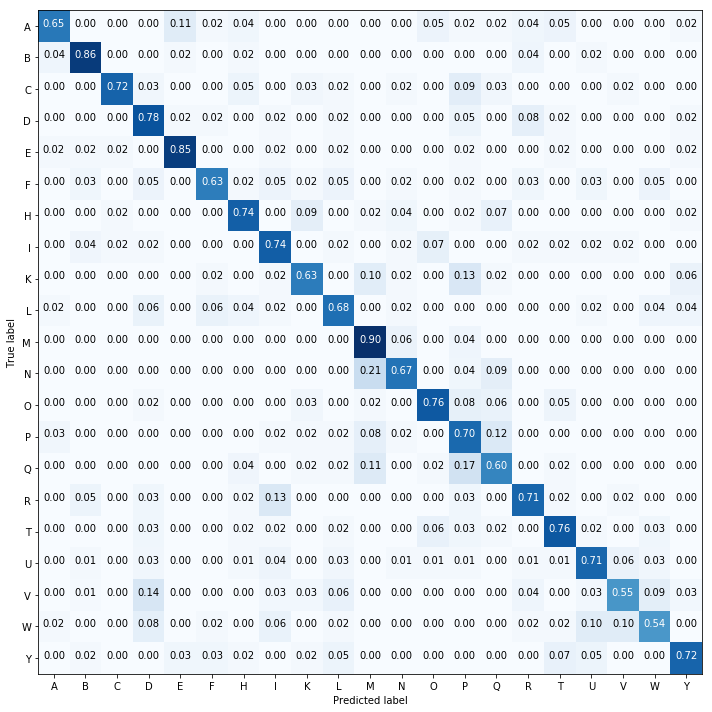

In [15]:
def generate_confussion_matrix():
    predictions_test = []
    label_test = []
    for i, (image_batch, label_batch) in enumerate(test_loader):
        if use_gpu:
            image_batch = image_batch.cuda()
            label_batch = label_batch.cuda()
        label_test.append(label_batch.detach().cpu().numpy())
        img_example = model.forward(image_batch)
        predictions_test.append(torch.softmax(img_example, dim=1).detach().cpu().numpy())

    predictions_test = np.concatenate(predictions_test, axis = 0)
    label_test = np.concatenate(label_test, axis = 0)

    import itertools
    from sklearn.metrics import confusion_matrix

    cm = confusion_matrix(label_test, np.argmax(predictions_test, axis = 1))
    cm = cm/np.sum(cm, axis=1, keepdims=True)

    fig, ax = plt.subplots(figsize=(10, 10), tight_layout=True)
    ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.set_xticks(np.arange(len(classes))); 
    ax.set_yticks(np.arange(len(classes)))
    ax.set_xticklabels(classes); ax.set_yticklabels(classes)
    ax.set_ylabel('True label'); ax.set_xlabel('Predicted label')
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], '.2f'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    fig.savefig(c_matrix_path, dpi=fig.dpi)
    print("Confussion matrix saved on :", c_matrix_path)

c_matrix_path    = results_path + experiment_name + experiment_name + ".png"
generate_confussion_matrix() 

# Testing

## Choose an image of the folder and show the class

Transform image shape:  torch.Size([1, 3, 224, 224])
Softmax
A 	 6.771%
B 	 0.709%
C 	 0.007%
D 	 59.25%
E 	 0.000%
F 	 0.091%
H 	 0.009%
I 	 0.012%
K 	 0.001%
L 	 0.005%
M 	 0.000%
N 	 2.273%
O 	 1.639%
P 	 3.933%
Q 	 2.695%
R 	 2.187%
T 	 0.000%
U 	 0.014%
V 	 0.351%
W 	 37.35%
Y 	 0.002%
Detected label: D
Accuracy: 59.25%


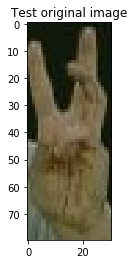

In [18]:
#If img_name = '' then choose a random image
test_img_folder = 'american/'
#test_img_folder = 'balanced/'

img_name = ''
#test_image_from_path(model, test_img_path, img_name, use_gpu, transform):
test_image_from_path(model, test_img_folder, img_name, use_gpu, transforms['valid'])

## Choose an random image of the test dataset and show the class

Softmax
A 	 1.155%
B 	 0.836%
C 	 0.066%
D 	 2.226%
E 	 1.495%
F 	 0.020%
H 	 0.262%
I 	 34.81%
K 	 0.192%
L 	 4.028%
M 	 0.317%
N 	 0.134%
O 	 0.356%
P 	 1.241%
Q 	 0.635%
R 	 6.693%
T 	 25.81%
U 	 8.592%
V 	 1.282%
W 	 3.483%
Y 	 6.349%
Detected label: I
Accuracy: 34.81%


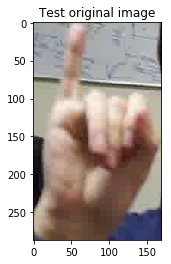

In [10]:
#test_image_from_dataset(model, use_gpu, transform, dataset)
test_image_from_dataset(model, use_gpu, transforms['valid'], partition['test'])